In [2]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

# Loading the data

In [3]:
df = pd.Series()
df['raw'] = pd.read_csv('./Data/clean.csv',index_col='Time_Stamp',low_memory=False)
#df['area'] = pd.read_csv('./Data/area.csv',index_col='Time stamp',low_memory=False)
df['raw'].shape

(38709, 6)

In [4]:
df['raw'].head()

,Weekday,Area,Sub_Area,Free_Spots,Used_Spots,Full%
Time_Stamp,,,,,,
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E MARION ST AND E SPRING ST,12.0,0.0,0.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST,13.0,7.0,35.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E SPRING ST AND E MADISON ST,15.0,4.0,21.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E JAMES CT AND E CHERRY ST,4.0,2.0,33.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,8.0,0.0,0.0


# Data exploration

Because this is an example, i will choose one specific parking area to predict. 

## Choosing the area

For reference, i will investigate the content of Parking_Spaces, as it is not clear what this means.

In [5]:
df['raw']['Sub_Area'].value_counts().head()

NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST        77
NW 54TH SR ST BETWEEN 30TH WR AVE NW AND 32ND AVE NW    75
MAYNARD AVE S BETWEEN S JACKSON ST AND S KING ST        67
7TH AVE S BETWEEN S MAIN ST AND S JACKSON ST            67
MAYNARD AVE S BETWEEN S KING ST AND S WELLER ST         66
Name: Sub_Area, dtype: int64

54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST is the parking spot with the most entries. These entries will be the ones used for modeling.

In [6]:
df['data'] = df['raw'][df['raw']['Sub_Area'].isin({'NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST'})]

## Exploration

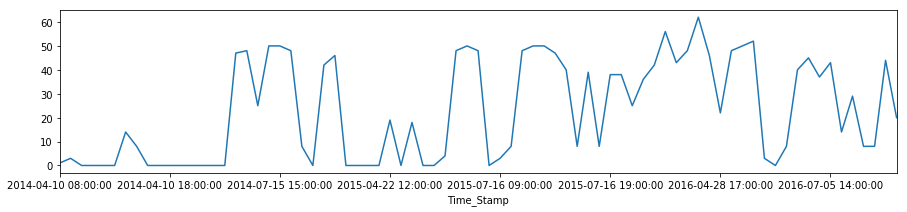

In [7]:
#Time series plot
plt.figure(figsize=(15,3));
df['data']['Full%'].plot();
plt.show();


In [8]:
df['data']['Free_Spots'].value_counts().head(10)

12.0     28
24.0     14
68.0     13
136.0    12
7.0       3
6.0       2
14.0      1
3.0       1
22.0      1
13.0      1
Name: Free_Spots, dtype: int64

Entire dataset


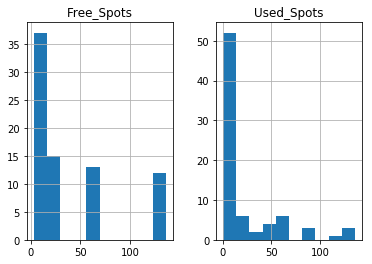

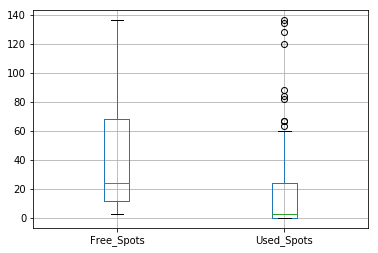

In [9]:
print('Entire dataset')
df['data'][['Free_Spots','Used_Spots']].hist()
plt.show()
df['data'][['Free_Spots','Used_Spots']].boxplot()
plt.show()

Weekdays


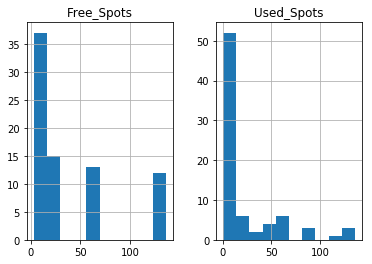

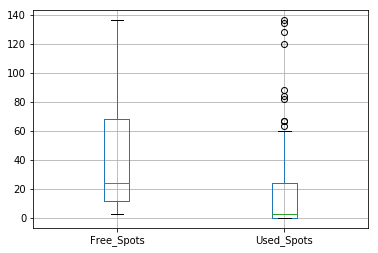

In [10]:
print('Weekdays')
obj = df['data'][df['data'].Weekday.isin({'Yes'})]
obj[['Free_Spots','Used_Spots']].hist()
plt.show()
obj[['Free_Spots','Used_Spots']].boxplot()
plt.show()

Weekends


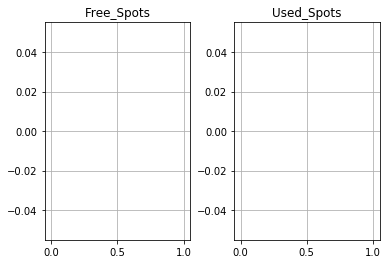

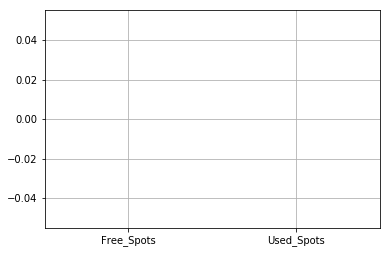

In [11]:
print('Weekends')
obj = df['data'][df['data'].Weekday.isin({'No'})]
obj[['Free_Spots','Used_Spots']].hist()
plt.show()
obj[['Free_Spots','Used_Spots']].boxplot()
plt.show()

The boxplots tell me that all observations was made on weekdays. This means i will not be able to guratantee the performance of weekends, as i cant validate the model on these days, and cannot look for differences between weekdays and weekends.

# Modeling

## Test train split
Before any modeling is done, the dataset will be spit into a test/train set.

In [86]:
from sklearn.model_selection import train_test_split
TRAIN,TEST,notused,notused = train_test_split(df['data']['Full%'],
                                                    df['data']['Full%'], 
                                                    test_size=0.25)
TRAIN.sort_index(inplace=True)
TEST.sort_index(inplace=True)

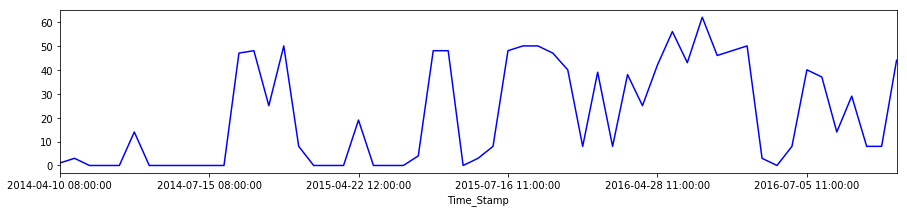

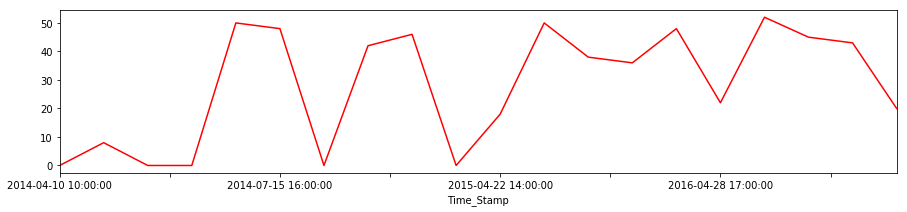

In [88]:
plt.figure(figsize=(15,3));
TRAIN.plot(color='blue')
plt.show();

plt.figure(figsize=(15,3));
TEST.plot(color='red',sharex=True)
plt.show()

## Modeling
### LSTM Recurrent Neural Network

To prepare the data for an LSTM network, i will have to create a x_train and y_train from the train part, and similarly for the test. the first entry of x_train should be TRAIN[0] and for y_train it should be TRAIN[1] because i am trying to predict the next value. I will have to discard the last value, as there is no y value for this entry.

In [112]:
# create train lists
x_train = []
y_train = []

# create test lists
x_test = []
y_test = []

# fill the train lists
for i in range(len(TRAIN)-1):
    x_train.append(TRAIN[i])
    y_train.append(TRAIN[i+1])

# fill the test lists
for i in range(len(TEST)-1):
    x_test.append(TEST[i])
    y_test.append(TEST[i+1])

# change the lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

print(x_train.shape)
print(x_test.shape)




(56,)
(19,)


In [75]:
trainX = x_train.reshape(x_train.shape[0], 1, 1)
trainY = y_train.reshape(y_train.shape[0], 1, 1)

In [101]:
x_train = x_train.reshape(1,56,1)
y_train = x_train.reshape(1,56,1)

#x_test = x_test.reshape(1,1,37)
#y_test = x_test.reshape(1,1,37)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

ValueError: Error when checking input: expected dense_41_input to have shape (None, 56) but got array with shape (56, 1)

In [110]:
model = Sequential()
model.add(LSTM(37, input_dim=37,return_sequences=True))
model.add(Dense(37))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10000, batch_size=1, verbose=2,validation_data=(x_test, y_test))

ValueError: Error when checking input: expected dense_38_input to have 2 dimensions, but got array with shape (1, 56, 1)

In [115]:
df['data'].head()

,Weekday,Area,Sub_Area,Free_Spots,Used_Spots,Full%
Time_Stamp,,,,,,
2014-04-10 08:00:00,Yes,Ballard Locks,NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST,68.0,1.0,1.0
2014-04-10 09:00:00,Yes,Ballard Locks,NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST,68.0,2.0,3.0
2014-04-10 10:00:00,Yes,Ballard Locks,NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST,12.0,0.0,0.0
2014-04-10 11:00:00,Yes,Ballard Locks,NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST,12.0,0.0,0.0
2014-04-10 12:00:00,Yes,Ballard Locks,NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST,12.0,0.0,0.0
